In [1]:
import numpy as np
from time import time
from PIL import Image
import torch
import torch.nn as nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
from backbones import get_model
from privacy_pipeline import Pipeline
import torch.nn.functional as F
from tqdm.auto import tqdm

In [2]:
DEVICE = torch.device("cuda")

# 获取 & 载入模型
net = get_model('r100',fp16=False).eval().to(DEVICE)
net.load_state_dict(torch.load('/private/data/backbone.pth'))

#这里的batch_size是干啥的: 用来在恢复的时候 一次sample几个出来
batch_size = 80
image_dim = 112

def tensorToImage(im):return ((im+1)/2).permute(1, 2, 0).cpu().detach().numpy()

from dataset import MXFaceDataset,DataLoaderX
# 载入数据集
train_set = MXFaceDataset('/private/data/ms1m-retinaface-t1',local_rank=0)
train_loader = DataLoaderX(local_rank=0,dataset=train_set,batch_size=1)

In [3]:
%%time
# test dataset time
l = []
with torch.no_grad():
    test = DataLoaderX(local_rank = 0,dataset = train_set, batch_size = 200)
    for X,y in tqdm(test):
        for i in range(4):
            xx=X[y==(torch.ones(y.shape[0]).cuda())*i]
            l.append(xx)
        break

  0%|          | 0/25898 [00:00<?, ?it/s]

CPU times: user 22.1 s, sys: 42.6 ms, total: 22.1 s
Wall time: 1.43 s


In [4]:
!ls save

1.tar  2.tar  emb_average.pt


In [5]:
for X in l:
    xx = X.sum(dim=0,keepdim=True)/X.shape[0]
    print(xx.shape)
    emb=F.normalize(net(xx))
    emb_center=torch.load('save/emb_average.pt')
    print((emb**2).sum(),(emb_center**2).sum())
    print((emb*emb_center).sum())
    # plt.imshow(tensorToImage(xx[0]))
    # plt.show()
    break

torch.Size([1, 3, 112, 112])
tensor(1., device='cuda:0', grad_fn=<SumBackward0>) tensor(1.0000, device='cuda:0')
tensor(0.4912, device='cuda:0', grad_fn=<SumBackward0>)


In [6]:
with torch.no_grad():
    for i in train_loader:
        l = i[0]
        break
    emb_target = net(l)
    print(emb_target,torch.norm(emb_target))
# plt.imshow(tensorToImage(l[0]))

tensor([[ 1.6947e+00,  6.0494e-01,  3.6573e-01, -1.0889e+00, -1.2422e+00,
         -2.4070e-02, -2.0370e-01, -6.4951e-01,  3.0734e-01, -1.0871e-01,
          7.3336e-02,  6.9699e-01,  3.1213e+00, -5.8355e-01,  1.8689e+00,
          6.7500e-01,  3.2741e-03, -2.5498e-01,  7.0444e-01,  2.0570e+00,
         -1.8712e-02,  2.3288e+00, -9.4237e-01,  1.8513e-02,  4.0161e-01,
          2.8675e-01,  5.0974e-01,  8.9397e-01,  8.7797e-01, -2.6162e+00,
          2.5628e-01, -6.3882e-01, -2.6917e+00, -2.1699e+00, -1.9033e+00,
         -1.4882e+00,  3.5346e-01, -1.9388e+00, -1.3690e+00,  2.7467e-01,
         -8.7504e-03,  5.5729e-01, -2.5348e+00, -1.6477e+00, -1.5301e+00,
         -1.1803e+00,  2.1530e+00, -5.7154e-02, -1.2929e+00, -2.2936e+00,
          1.6459e+00,  1.4092e+00, -7.5809e-01, -1.4781e+00,  1.3494e+00,
          2.3578e+00, -5.4281e-01, -2.3947e+00,  2.1731e+00,  2.5591e+00,
          1.1832e+00, -1.7977e+00,  1.1435e+00, -6.6756e-01,  7.6562e-01,
         -1.0906e+00, -1.9724e+00,  1.

In [7]:
pipeline = Pipeline(emb_target,
                    net,
                    DEVICE,
                    dim=image_dim,
                    batch_size=batch_size,
                    sym_part=1,
                    multistart=True,
                    gauss_amplitude=0.1,
                    color=False,
                    )

In [8]:
(emb_target**2).sum()

tensor(814.3382, device='cuda:0')

In [9]:
cosines_target = []
facenet_sims = []

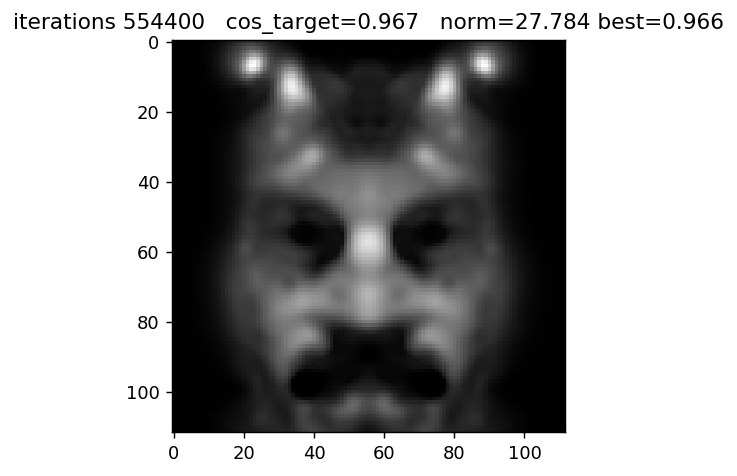

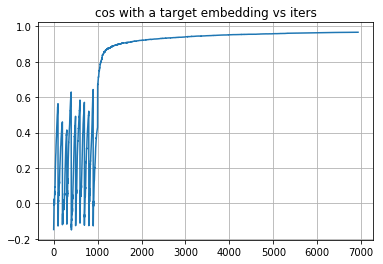

In [ ]:
with torch.no_grad():
    for i in range(15000):
        start = time()
        
        recovered_face, cos_target = pipeline()
        
        cosines_target.append(cos_target)
        
        
        if i % 10 == 0:
            clear_output(wait=True)
            recovered_face = np.transpose(recovered_face.cpu().detach().numpy(),(1,2,0))
            recovered_face = recovered_face - np.min(recovered_face)
            recovered_face = recovered_face / np.max(recovered_face)
            
            plt.figure(dpi=130)
            plt.imshow(recovered_face)
            plt.title(f"iterations {i*pipeline.batch_size}   cos_target={round(cos_target,3)}   norm={round(pipeline.norm,3)} best={(round(pipeline.best_value.item(),3))}")
            plt.show()
            
            plt.plot(cosines_target)
            plt.grid()
            plt.title("cos with a target embedding vs iters")
            plt.show()
# 继续除了 clamp以外, 还变了 gauss的产生方式, 这样可能出来有点奇怪么?